In [14]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import scipy

In [15]:
pretrain_model_num_correct = (np.load("ckpts/base_model_few_shot_accuracy/triviaqa/test_12.npy")==0).sum(axis=-1)
bins = np.array([0, 2, 4, 6, 8, 10, 12])

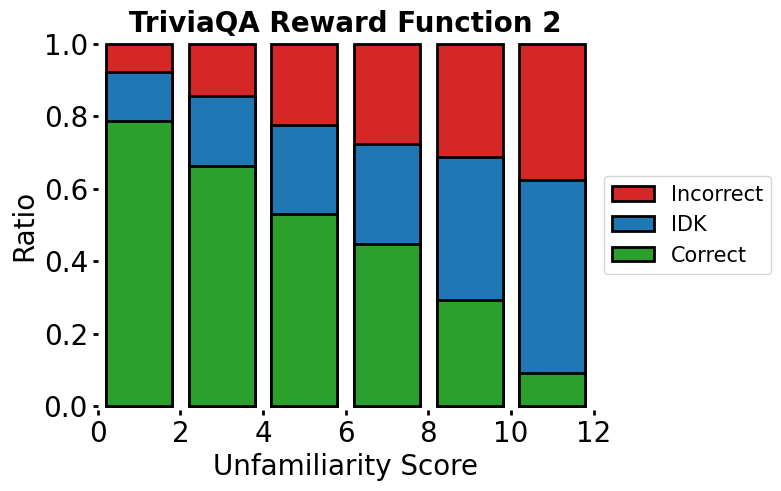

In [35]:
# model_path = "ckpts/sft_triviaqa_random_0/checkpoint_10000/hf_model/"
# title_name = "TriviaQA Finetuning Distribution 1"
# save_name = "triviaqa_sft1"
# model_path = "ckpts/sft_triviaqa_random_40/checkpoint_10000/hf_model/"
# title_name = "TriviaQA Finetuning Distribution 3"
# save_name = "triviaqa_sft3"
# model_path = "ckpts/sft_triviaqa_unfamiliar_40/checkpoint_10000/hf_model/"
# title_name = "TriviaQA Finetuning Distribution 2"
# save_name = "triviaqa_sft2"
model_path = "ckpts/ppo_triviaqa_correct2_incorrect-3_idk0_kl0.1/checkpoint_030000/hf_model/"
title_name = "TriviaQA Reward Function 2"
save_name = "triviaqa_rl2"
# model_path = "ckpts/ppo_triviaqa_correct2_incorrect-3_idk-3_kl0.1/checkpoint_030000/hf_model/"
# title_name = "TriviaQA Reward Function 1"
# save_name = "triviaqa_rl1"

test_samples_answer_types = np.load(os.path.join(model_path, "test_samples_answer_types_temp1.npy"))
answers_correct = (test_samples_answer_types==0)
answers_dont_know = (test_samples_answer_types==2)


accuracies = []
dont_know_frac = []

for i in range(len(bins) - 1):
    bin_lower = bins[i]
    bin_upper = bins[i + 1]

    indices = np.where((pretrain_model_num_correct >= bin_lower) & (pretrain_model_num_correct < bin_upper))[0]

    accuracies.append(np.mean(answers_correct[indices]))
    dont_know_frac.append(np.mean(answers_dont_know[indices]))

accuracies = np.array(accuracies)
dont_know_frac = np.array(dont_know_frac)

plt.bar([0, 1, 2, 3, 4, 5], [1, 1, 1, 1, 1, 1], color="tab:red", label = "Incorrect", edgecolor='black',linewidth=2, width=0.8)
plt.bar([0, 1, 2, 3, 4, 5], np.flip(accuracies+dont_know_frac), color="tab:blue", label="IDK", edgecolor='black',linewidth=2, width=0.8)
plt.bar([0, 1, 2, 3, 4, 5], np.flip(accuracies), color="tab:green", label = "Correct", edgecolor='black',linewidth=2, width=0.8)

plt.xlabel("Unfamiliarity Score", fontsize=20)
plt.ylabel("Ratio", fontsize=20)
plt.ylim([-0.01, 1.01])
plt.xlim([-0, 4.5])

plt.xticks(np.array([0, 1, 2, 3, 4, 5, 6])-0.5, bins, fontsize=20)

plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='major', width=2)
plt.box(False)

plt.title(title_name, fontsize=20, weight="bold")
plt.legend(fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("figures/"+save_name+".png", bbox_inches='tight', dpi=300)

# plt.legend(fontsize=15, loc='right')
# put legend on right of figure outside


In [22]:
def get_bin_stats(x_axis, y_axis, bins):
    x_axis = np.array(x_axis)
    y_axis = np.array(y_axis)
    bin_avgs = []
    bin_stds = []
    for i in range(len(bins)-1):
        idxs = np.where((x_axis >= bins[i]) & (x_axis < bins[i+1]))[0]
        # print(len(idxs))
        bin_avgs.append(np.mean(y_axis[idxs]))
        bin_stds.append(np.std(y_axis[idxs]))
    return np.array(bin_avgs), np.array(bin_stds)

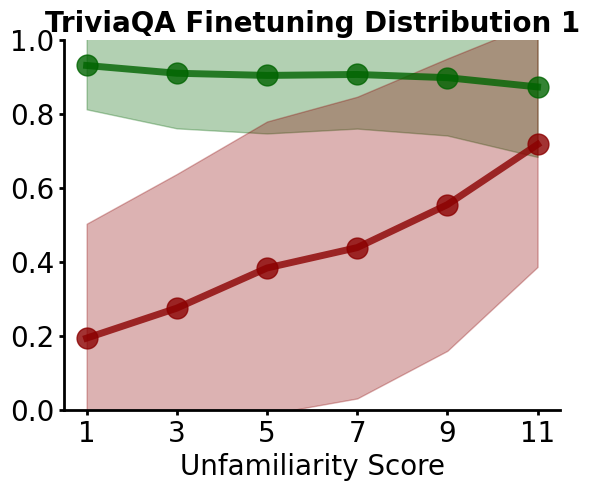

In [27]:
model_path = "ckpts/rm_triviaqa_unfamiliar_correct_2/checkpoint_08000/hf_model/"
title_name = "TriviaQA Finetuning Distribution 1"
save_name = "triviaqa_rm1"

# model_path = "ckpts/rm_triviaqa_unfamiliar_incorrect_2/checkpoint_08000/hf_model/"
# title_name = "TriviaQA Finetuning Distribution 2"
# save_name = "triviaqa_rm2"

true_false_logits = np.load(os.path.join(model_path, "test_correct_only_logits.npy"))
true_false_logits =  scipy.special.softmax(true_false_logits, axis=-1)

bin_avgs, bin_stds = get_bin_stats(pretrain_model_num_correct, true_false_logits[:, 0],  bins, )

plt.plot([0, 1, 2, 3, 4, 5], np.flip(bin_avgs), "o-", linewidth=5, markersize=15, alpha=0.8, color="darkgreen")
plt.fill_between([0, 1, 2, 3, 4, 5], np.flip(bin_avgs-bin_stds), np.flip(bin_avgs+bin_stds), alpha=0.3, color="darkgreen")


true_false_logits = np.load(os.path.join(model_path, "test_incorrect_only_logits.npy"))
true_false_logits =  scipy.special.softmax(true_false_logits, axis=-1)

bin_avgs, bin_stds = get_bin_stats(pretrain_model_num_correct, true_false_logits[:, 0],  bins, )

plt.plot([0, 1, 2, 3, 4, 5], np.flip(bin_avgs), "o-", linewidth=5, markersize=15, alpha=0.8, color="darkred")
plt.fill_between([0, 1, 2, 3, 4, 5], np.flip(bin_avgs-bin_stds), np.flip(bin_avgs+bin_stds), alpha=0.3, color="darkred")

# plt.ylabel("Predicted Likelihood of \nReward 1", fontsize=20)
plt.xlabel("Unfamiliarity Score", fontsize=20)
plt.title(title_name, fontsize=20, weight="bold")


plt.xticks([0, 1, 2, 3, 4, 5], bins[:-1]+1, fontsize=20)

plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='major', width=2)

# remove top border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.ylim(0, 1)

plt.savefig("figures/"+save_name+".png", bbox_inches='tight', dpi=300)
